下面我们开始尝试做图形的预处理。

图片亮度调整：
https://www.programcreek.com/python/example/93845/skimage.exposure.adjust_gamma
    
http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.adjust_gamma
    
        

../data/sandbox/03755
shape of images is:  (120, 64, 64)
sandbox:  120 531 [[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
image_data:  [[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


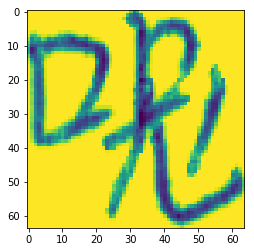

In [4]:
import os
import random
from PIL import *
from numpy import array
import numpy as np

IMAGE_SIZE = 64
CHARSET_SIZE = 3755

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import adjust_gamma

class DataIterator:
    def __init__(self, data_dir):
        # Set FLAGS.charset_size to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print(truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        image_gamma_adjust = [adjust_gamma(image, 1) for image in image_resized]
        self.images = [rgb2gray(item) for item in image_gamma_adjust]
        self.images = array(self.images)
        print ('shape of images is: ', self.images.shape)

    @property
    def size(self):
        return len(self.labels)
    
test_feeder = DataIterator(data_dir='../data/sandbox/')
print ('sandbox: ', test_feeder.size, test_feeder.labels[0], test_feeder.images[0])


# show image
import matplotlib.pyplot as plt
first_array=test_feeder.images[0]
image_data = first_array.reshape((IMAGE_SIZE, IMAGE_SIZE))
print ('image_data: ', image_data)


#Not sure you even have to do that if you just want to visualize it
#first_array=255*first_array
#first_array=first_array.astype("uint8")
plt.imshow(image_data)
#Actually displaying the plot if you are not in interactive mode
plt.show()


gamma值不能为负数；小于1时，感觉为虚化；大于1时，感觉为清晰。gamma越大，感觉字越黑。
gamma不能为0，为0时啥也看不到了。
下面生成3个随机数；第一个决定使用第2或第3个。第2个在0.001到1之间；第3个在1到100之间。
gamma可以是浮点数。调整gamma，会影响图片的清晰度

下面开始，使用随机gamma校正，进行训练：



In [1]:
import numpy as np

def getRndGamma():
    rnd1 = np.random.random_sample()
    rnd2 = np.random.random_sample()+0.001
    rnd3 = np.random.random_sample()*100

    if (rnd1 < 1/3.0):
        return rnd3
    elif (rnd1 < 2/3.0):
        return 1
    else:
        return rnd2
    
for i in range(10):
    print ('Now gamma is --: ', getRndGamma())


Now gamma is --:  47.55773136000959
Now gamma is --:  1
Now gamma is --:  46.864486558905114
Now gamma is --:  1
Now gamma is --:  11.103382020645657
Now gamma is --:  0.5200820321064661
Now gamma is --:  1
Now gamma is --:  1
Now gamma is --:  1
Now gamma is --:  23.87636264320765


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import adjust_gamma

IMAGE_SIZE = 64
FULL_CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def getRndGamma():
    rnd1 = np.random.random_sample()
    rnd2 = np.random.random_sample()+0.001
    rnd3 = np.random.random_sample()*100

    if (rnd1 > 0.5):
        return rnd3
    else:
        return rnd2

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        image_gamma_adjusted = [adjust_gamma(image, getRndGamma()) for image in image_resized]
        self.images = [rgb2gray(item) for item in image_gamma_adjusted]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

# Build 2 layer DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[1024, 1024, 1024, 1024, 1024],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1,
    model_dir="../dfs/checkpoint/dnn7_model_c"
)
for i in range(10):
    train_data = DataSetLoader(data_dir='../data/train_/')
    print ('Train data loaded for the %d times.'%(i+1))
    # Define the training inputs
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": input(train_data)[0]},
        y=input(train_data)[1],
        num_epochs=None,
        batch_size=50,
        shuffle=True
    )

    classifier.train(input_fn=train_input_fn, steps=20000)


print ('Train done, begin to test ...')
test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../dfs/checkpoint/dnn7_model_c', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
Now processing path:  ../data/train_/00037
Train data loaded for the 1 times.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-120000
INFO:tensorflow:Saving checkpoints for 120001 into ../dfs/checkpoint/dnn7_model_c/model.ckpt.
INFO:tensorflow:loss = 13.151, step = 120001
INFO:tensorflow:global_step/sec: 7.4398
INFO:tensorflow:loss = 8.84369, step = 120101 (13.445 sec)
INFO:tensorflow:global_step/sec: 7.76822
INFO:tensorflow:loss = 11.4761, step = 120201 (12.873 sec)
INFO:tensorflow:global_step/sec: 7.9771
INFO:tensorflow:loss = 25.2473, step = 120301 (12.534 s

INFO:tensorflow:loss = 6.20382, step = 128401 (14.248 sec)
INFO:tensorflow:global_step/sec: 7.07289
INFO:tensorflow:loss = 8.71514, step = 128501 (14.139 sec)
INFO:tensorflow:global_step/sec: 7.21313
INFO:tensorflow:loss = 8.87886, step = 128601 (13.864 sec)
INFO:tensorflow:global_step/sec: 7.06561
INFO:tensorflow:loss = 4.07013, step = 128701 (14.153 sec)
INFO:tensorflow:global_step/sec: 6.95208
INFO:tensorflow:loss = 15.0524, step = 128801 (14.384 sec)
INFO:tensorflow:global_step/sec: 7.09165
INFO:tensorflow:loss = 13.09, step = 128901 (14.102 sec)
INFO:tensorflow:global_step/sec: 6.73176
INFO:tensorflow:loss = 7.08102, step = 129001 (14.861 sec)
INFO:tensorflow:global_step/sec: 6.90131
INFO:tensorflow:loss = 6.23313, step = 129101 (14.483 sec)
INFO:tensorflow:global_step/sec: 6.97276
INFO:tensorflow:loss = 2.79692, step = 129201 (14.344 sec)
INFO:tensorflow:Saving checkpoints for 129235 into ../dfs/checkpoint/dnn7_model_c/model.ckpt.
INFO:tensorflow:global_step/sec: 5.93849
INFO:ten

INFO:tensorflow:global_step/sec: 7.63517
INFO:tensorflow:loss = 10.285, step = 136501 (13.098 sec)
INFO:tensorflow:global_step/sec: 7.76214
INFO:tensorflow:loss = 6.36169, step = 136601 (12.883 sec)
INFO:tensorflow:global_step/sec: 7.6741
INFO:tensorflow:loss = 5.09078, step = 136701 (13.034 sec)
INFO:tensorflow:global_step/sec: 7.61742
INFO:tensorflow:loss = 4.09672, step = 136801 (13.124 sec)
INFO:tensorflow:global_step/sec: 11.8825
INFO:tensorflow:loss = 12.8001, step = 136901 (8.416 sec)
INFO:tensorflow:global_step/sec: 13.2264
INFO:tensorflow:loss = 10.4587, step = 137001 (7.560 sec)
INFO:tensorflow:global_step/sec: 12.6315
INFO:tensorflow:loss = 18.6392, step = 137101 (7.917 sec)
INFO:tensorflow:global_step/sec: 10.6988
INFO:tensorflow:loss = 20.3304, step = 137201 (9.347 sec)
INFO:tensorflow:global_step/sec: 7.68445
INFO:tensorflow:loss = 10.9279, step = 137301 (13.013 sec)
INFO:tensorflow:global_step/sec: 7.83847
INFO:tensorflow:loss = 4.78826, step = 137401 (12.758 sec)
INFO:t

INFO:tensorflow:loss = 19.8344, step = 144201 (12.309 sec)
INFO:tensorflow:global_step/sec: 8.63029
INFO:tensorflow:loss = 13.6517, step = 144301 (11.587 sec)
INFO:tensorflow:global_step/sec: 13.3373
INFO:tensorflow:loss = 1.57766, step = 144401 (7.497 sec)
INFO:tensorflow:global_step/sec: 12.282
INFO:tensorflow:loss = 4.78487, step = 144501 (8.142 sec)
INFO:tensorflow:global_step/sec: 12.4991
INFO:tensorflow:loss = 8.14432, step = 144601 (8.001 sec)
INFO:tensorflow:global_step/sec: 12.8566
INFO:tensorflow:loss = 13.6677, step = 144701 (7.778 sec)
INFO:tensorflow:global_step/sec: 11.5204
INFO:tensorflow:loss = 4.64843, step = 144801 (8.680 sec)
INFO:tensorflow:global_step/sec: 9.22897
INFO:tensorflow:loss = 11.8161, step = 144901 (10.835 sec)
INFO:tensorflow:global_step/sec: 13.5279
INFO:tensorflow:loss = 11.2381, step = 145001 (7.392 sec)
INFO:tensorflow:Saving checkpoints for 145029 into ../dfs/checkpoint/dnn7_model_c/model.ckpt.
INFO:tensorflow:global_step/sec: 11.5734
INFO:tensorfl

INFO:tensorflow:loss = 4.84507, step = 152401 (6.683 sec)
INFO:tensorflow:global_step/sec: 15.4815
INFO:tensorflow:loss = 7.08795, step = 152501 (6.456 sec)
INFO:tensorflow:global_step/sec: 15.6528
INFO:tensorflow:loss = 7.50112, step = 152601 (6.388 sec)
INFO:tensorflow:global_step/sec: 16.1077
INFO:tensorflow:loss = 10.6811, step = 152701 (6.207 sec)
INFO:tensorflow:global_step/sec: 15.6241
INFO:tensorflow:loss = 13.8058, step = 152801 (6.401 sec)
INFO:tensorflow:global_step/sec: 16.1303
INFO:tensorflow:loss = 11.5768, step = 152901 (6.199 sec)
INFO:tensorflow:global_step/sec: 16.1436
INFO:tensorflow:loss = 1.75033, step = 153001 (6.195 sec)
INFO:tensorflow:global_step/sec: 15.3074
INFO:tensorflow:loss = 9.05472, step = 153101 (6.534 sec)
INFO:tensorflow:global_step/sec: 15.4728
INFO:tensorflow:loss = 1.22645, step = 153201 (6.463 sec)
INFO:tensorflow:global_step/sec: 15.5532
INFO:tensorflow:loss = 16.4838, step = 153301 (6.431 sec)
INFO:tensorflow:global_step/sec: 15.4719
INFO:tenso

INFO:tensorflow:loss = 12.6051, step = 160201 (6.583 sec)
INFO:tensorflow:global_step/sec: 15.2201
INFO:tensorflow:loss = 6.27694, step = 160301 (6.570 sec)
INFO:tensorflow:global_step/sec: 15.8047
INFO:tensorflow:loss = 12.5494, step = 160401 (6.328 sec)
INFO:tensorflow:global_step/sec: 16.0948
INFO:tensorflow:loss = 17.6238, step = 160501 (6.212 sec)
INFO:tensorflow:global_step/sec: 15.9184
INFO:tensorflow:loss = 7.18395, step = 160601 (6.283 sec)
INFO:tensorflow:global_step/sec: 15.9142
INFO:tensorflow:loss = 4.40193, step = 160701 (6.283 sec)
INFO:tensorflow:global_step/sec: 16.0742
INFO:tensorflow:loss = 2.82466, step = 160801 (6.221 sec)
INFO:tensorflow:global_step/sec: 16.0203
INFO:tensorflow:loss = 0.954325, step = 160901 (6.242 sec)
INFO:tensorflow:global_step/sec: 16.1241
INFO:tensorflow:loss = 4.46741, step = 161001 (6.202 sec)
INFO:tensorflow:global_step/sec: 15.8822
INFO:tensorflow:loss = 10.0173, step = 161101 (6.296 sec)
INFO:tensorflow:global_step/sec: 16.2781
INFO:tens

INFO:tensorflow:loss = 8.35907, step = 168501 (6.334 sec)
INFO:tensorflow:global_step/sec: 16.3193
INFO:tensorflow:loss = 5.77943, step = 168601 (6.127 sec)
INFO:tensorflow:global_step/sec: 16.3422
INFO:tensorflow:loss = 7.12118, step = 168701 (6.118 sec)
INFO:tensorflow:global_step/sec: 15.7025
INFO:tensorflow:loss = 2.57025, step = 168801 (6.369 sec)
INFO:tensorflow:global_step/sec: 16.2237
INFO:tensorflow:loss = 4.91734, step = 168901 (6.164 sec)
INFO:tensorflow:global_step/sec: 16.1849
INFO:tensorflow:loss = 5.10961, step = 169001 (6.178 sec)
INFO:tensorflow:global_step/sec: 16.1214
INFO:tensorflow:loss = 7.38757, step = 169101 (6.204 sec)
INFO:tensorflow:global_step/sec: 16.0315
INFO:tensorflow:loss = 5.73649, step = 169201 (6.238 sec)
INFO:tensorflow:global_step/sec: 16.1801
INFO:tensorflow:loss = 7.82925, step = 169301 (6.180 sec)
INFO:tensorflow:global_step/sec: 16.2145
INFO:tensorflow:loss = 15.4063, step = 169401 (6.166 sec)
INFO:tensorflow:global_step/sec: 15.9717
INFO:tenso

INFO:tensorflow:loss = 5.5103, step = 176701 (6.168 sec)
INFO:tensorflow:global_step/sec: 16.1242
INFO:tensorflow:loss = 9.82498, step = 176801 (6.202 sec)
INFO:tensorflow:global_step/sec: 16.1847
INFO:tensorflow:loss = 9.51934, step = 176901 (6.179 sec)
INFO:tensorflow:global_step/sec: 16.037
INFO:tensorflow:loss = 10.5666, step = 177001 (6.235 sec)
INFO:tensorflow:global_step/sec: 16.3131
INFO:tensorflow:loss = 10.1647, step = 177101 (6.130 sec)
INFO:tensorflow:global_step/sec: 15.8566
INFO:tensorflow:loss = 15.4718, step = 177201 (6.307 sec)
INFO:tensorflow:global_step/sec: 16.1797
INFO:tensorflow:loss = 15.4806, step = 177301 (6.180 sec)
INFO:tensorflow:global_step/sec: 16.1449
INFO:tensorflow:loss = 12.5346, step = 177401 (6.194 sec)
INFO:tensorflow:global_step/sec: 16.1425
INFO:tensorflow:loss = 16.1612, step = 177501 (6.195 sec)
INFO:tensorflow:global_step/sec: 15.8595
INFO:tensorflow:loss = 5.06535, step = 177601 (6.306 sec)
INFO:tensorflow:global_step/sec: 16.1814
INFO:tensorf

INFO:tensorflow:global_step/sec: 15.1728
INFO:tensorflow:loss = 2.0866, step = 184601 (6.591 sec)
INFO:tensorflow:global_step/sec: 15.4803
INFO:tensorflow:loss = 11.9044, step = 184701 (6.459 sec)
INFO:tensorflow:global_step/sec: 15.5401
INFO:tensorflow:loss = 5.09844, step = 184801 (6.435 sec)
INFO:tensorflow:global_step/sec: 15.3747
INFO:tensorflow:loss = 0.301294, step = 184901 (6.505 sec)
INFO:tensorflow:global_step/sec: 15.3141
INFO:tensorflow:loss = 13.3295, step = 185001 (6.532 sec)
INFO:tensorflow:global_step/sec: 15.1978
INFO:tensorflow:loss = 12.8405, step = 185101 (6.578 sec)
INFO:tensorflow:global_step/sec: 15.3532
INFO:tensorflow:loss = 1.0461, step = 185201 (6.515 sec)
INFO:tensorflow:global_step/sec: 15.7267
INFO:tensorflow:loss = 6.34762, step = 185301 (6.357 sec)
INFO:tensorflow:global_step/sec: 16.097
INFO:tensorflow:loss = 2.36633, step = 185401 (6.212 sec)
INFO:tensorflow:global_step/sec: 16.0497
INFO:tensorflow:loss = 9.47828, step = 185501 (6.231 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 15.5763
INFO:tensorflow:loss = 10.8345, step = 192801 (6.420 sec)
INFO:tensorflow:global_step/sec: 15.564
INFO:tensorflow:loss = 40.3487, step = 192901 (6.424 sec)
INFO:tensorflow:global_step/sec: 15.4797
INFO:tensorflow:loss = 11.8341, step = 193001 (6.461 sec)
INFO:tensorflow:global_step/sec: 15.5844
INFO:tensorflow:loss = 10.4449, step = 193101 (6.416 sec)
INFO:tensorflow:global_step/sec: 15.3552
INFO:tensorflow:loss = 0.677688, step = 193201 (6.512 sec)
INFO:tensorflow:global_step/sec: 15.1645
INFO:tensorflow:loss = 3.79108, step = 193301 (6.595 sec)
INFO:tensorflow:global_step/sec: 15.1894
INFO:tensorflow:loss = 16.4195, step = 193401 (6.583 sec)
INFO:tensorflow:global_step/sec: 15.0583
INFO:tensorflow:loss = 4.00608, step = 193501 (6.641 sec)
INFO:tensorflow:global_step/sec: 14.9551
INFO:tensorflow:loss = 5.69974, step = 193601 (6.687 sec)
INFO:tensorflow:global_step/sec: 14.9618
INFO:tensorflow:loss = 12.1507, step = 193701 (6.684 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 15.5997
INFO:tensorflow:loss = 4.0302, step = 200601 (6.407 sec)
INFO:tensorflow:global_step/sec: 15.6684
INFO:tensorflow:loss = 7.3515, step = 200701 (6.383 sec)
INFO:tensorflow:global_step/sec: 15.6437
INFO:tensorflow:loss = 20.8273, step = 200801 (6.394 sec)
INFO:tensorflow:global_step/sec: 16.0061
INFO:tensorflow:loss = 3.34711, step = 200901 (6.245 sec)
INFO:tensorflow:global_step/sec: 15.7842
INFO:tensorflow:loss = 3.47663, step = 201001 (6.337 sec)
INFO:tensorflow:global_step/sec: 15.6992
INFO:tensorflow:loss = 8.72738, step = 201101 (6.368 sec)
INFO:tensorflow:global_step/sec: 16.0643
INFO:tensorflow:loss = 3.59216, step = 201201 (6.225 sec)
INFO:tensorflow:global_step/sec: 15.8473
INFO:tensorflow:loss = 12.3026, step = 201301 (6.310 sec)
INFO:tensorflow:global_step/sec: 16.0836
INFO:tensorflow:loss = 16.9897, step = 201401 (6.218 sec)
INFO:tensorflow:global_step/sec: 15.9795
INFO:tensorflow:loss = 6.35002, step = 201501 (6.258 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 16.2019
INFO:tensorflow:loss = 1.95837, step = 208901 (6.172 sec)
INFO:tensorflow:global_step/sec: 16.1496
INFO:tensorflow:loss = 6.13334, step = 209001 (6.193 sec)
INFO:tensorflow:global_step/sec: 16.1703
INFO:tensorflow:loss = 0.864274, step = 209101 (6.184 sec)
INFO:tensorflow:global_step/sec: 16.0847
INFO:tensorflow:loss = 3.89902, step = 209201 (6.217 sec)
INFO:tensorflow:global_step/sec: 16.122
INFO:tensorflow:loss = 6.36259, step = 209301 (6.203 sec)
INFO:tensorflow:global_step/sec: 16.1376
INFO:tensorflow:loss = 2.03562, step = 209401 (6.196 sec)
INFO:tensorflow:global_step/sec: 16.0973
INFO:tensorflow:loss = 8.32544, step = 209501 (6.212 sec)
INFO:tensorflow:global_step/sec: 16.1343
INFO:tensorflow:loss = 12.512, step = 209601 (6.198 sec)
INFO:tensorflow:Saving checkpoints for 209618 into ../dfs/checkpoint/dnn7_model_c/model.ckpt.
INFO:tensorflow:global_step/sec: 13.3184
INFO:tensorflow:loss = 12.4298, step = 209701 (7.508 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 15.3517
INFO:tensorflow:loss = 3.92365, step = 217101 (6.514 sec)
INFO:tensorflow:global_step/sec: 15.6738
INFO:tensorflow:loss = 12.977, step = 217201 (6.380 sec)
INFO:tensorflow:global_step/sec: 15.2699
INFO:tensorflow:loss = 9.88844, step = 217301 (6.549 sec)
INFO:tensorflow:global_step/sec: 15.5245
INFO:tensorflow:loss = 15.6574, step = 217401 (6.441 sec)
INFO:tensorflow:global_step/sec: 15.1414
INFO:tensorflow:loss = 14.9162, step = 217501 (6.604 sec)
INFO:tensorflow:global_step/sec: 15.0345
INFO:tensorflow:loss = 6.77997, step = 217601 (6.652 sec)
INFO:tensorflow:global_step/sec: 14.9746
INFO:tensorflow:loss = 0.357148, step = 217701 (6.678 sec)
INFO:tensorflow:global_step/sec: 14.9383
INFO:tensorflow:loss = 3.27831, step = 217801 (6.694 sec)
INFO:tensorflow:global_step/sec: 14.8633
INFO:tensorflow:loss = 2.97971, step = 217901 (6.728 sec)
INFO:tensorflow:global_step/sec: 14.857
INFO:tensorflow:loss = 5.38236, step = 218001 (6.731 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 16.0843
INFO:tensorflow:loss = 3.02183, step = 224901 (6.217 sec)
INFO:tensorflow:global_step/sec: 16.2145
INFO:tensorflow:loss = 10.4063, step = 225001 (6.168 sec)
INFO:tensorflow:global_step/sec: 16.1141
INFO:tensorflow:loss = 5.56024, step = 225101 (6.205 sec)
INFO:tensorflow:global_step/sec: 16.1204
INFO:tensorflow:loss = 15.9477, step = 225201 (6.204 sec)
INFO:tensorflow:global_step/sec: 15.999
INFO:tensorflow:loss = 3.67483, step = 225301 (6.251 sec)
INFO:tensorflow:global_step/sec: 16.1528
INFO:tensorflow:loss = 11.6913, step = 225401 (6.190 sec)
INFO:tensorflow:global_step/sec: 16.2271
INFO:tensorflow:loss = 6.52229, step = 225501 (6.162 sec)
INFO:tensorflow:global_step/sec: 16.0078
INFO:tensorflow:loss = 5.16492, step = 225601 (6.247 sec)
INFO:tensorflow:global_step/sec: 16.075
INFO:tensorflow:loss = 7.13385, step = 225701 (6.221 sec)
INFO:tensorflow:global_step/sec: 16.1254
INFO:tensorflow:loss = 1.97108, step = 225801 (6.201 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 15.1594
INFO:tensorflow:loss = 5.20679, step = 234901 (6.596 sec)
INFO:tensorflow:global_step/sec: 15.0862
INFO:tensorflow:loss = 9.13642, step = 235001 (6.630 sec)
INFO:tensorflow:global_step/sec: 14.6307
INFO:tensorflow:loss = 4.00952, step = 235101 (6.837 sec)
INFO:tensorflow:global_step/sec: 15.1081
INFO:tensorflow:loss = 1.76797, step = 235201 (6.619 sec)
INFO:tensorflow:global_step/sec: 15.7475
INFO:tensorflow:loss = 3.7778, step = 235301 (6.348 sec)
INFO:tensorflow:global_step/sec: 16.0522
INFO:tensorflow:loss = 0.473622, step = 235401 (6.230 sec)
INFO:tensorflow:global_step/sec: 16.0142
INFO:tensorflow:loss = 13.0199, step = 235501 (6.244 sec)
INFO:tensorflow:global_step/sec: 15.781
INFO:tensorflow:loss = 15.8522, step = 235601 (6.337 sec)
INFO:tensorflow:global_step/sec: 15.8566
INFO:tensorflow:loss = 11.6897, step = 235701 (6.306 sec)
INFO:tensorflow:global_step/sec: 15.7788
INFO:tensorflow:loss = 8.52103, step = 235801 (6.337 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 15.6328
INFO:tensorflow:loss = 4.46963, step = 242701 (6.397 sec)
INFO:tensorflow:global_step/sec: 15.4539
INFO:tensorflow:loss = 10.1335, step = 242801 (6.471 sec)
INFO:tensorflow:global_step/sec: 15.451
INFO:tensorflow:loss = 5.28897, step = 242901 (6.472 sec)
INFO:tensorflow:global_step/sec: 15.2699
INFO:tensorflow:loss = 5.62397, step = 243001 (6.549 sec)
INFO:tensorflow:global_step/sec: 15.1537
INFO:tensorflow:loss = 8.91794, step = 243101 (6.599 sec)
INFO:tensorflow:global_step/sec: 14.583
INFO:tensorflow:loss = 2.81355, step = 243201 (6.857 sec)
INFO:tensorflow:global_step/sec: 15.0611
INFO:tensorflow:loss = 1.1725, step = 243301 (6.643 sec)
INFO:tensorflow:global_step/sec: 15.468
INFO:tensorflow:loss = 7.24437, step = 243401 (6.462 sec)
INFO:tensorflow:global_step/sec: 15.9719
INFO:tensorflow:loss = 25.23, step = 243501 (6.261 sec)
INFO:tensorflow:global_step/sec: 15.7163
INFO:tensorflow:loss = 4.71667, step = 243601 (6.363 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 6.55502, step = 250901 (6.343 sec)
INFO:tensorflow:global_step/sec: 15.3805
INFO:tensorflow:loss = 6.05874, step = 251001 (6.502 sec)
INFO:tensorflow:global_step/sec: 15.3633
INFO:tensorflow:loss = 10.8604, step = 251101 (6.509 sec)
INFO:tensorflow:global_step/sec: 15.1558
INFO:tensorflow:loss = 12.2769, step = 251201 (6.600 sec)
INFO:tensorflow:global_step/sec: 15.8756
INFO:tensorflow:loss = 9.34894, step = 251301 (6.299 sec)
INFO:tensorflow:global_step/sec: 16.0263
INFO:tensorflow:loss = 1.54584, step = 251401 (6.238 sec)
INFO:tensorflow:global_step/sec: 15.7283
INFO:tensorflow:loss = 1.50123, step = 251501 (6.358 sec)
INFO:tensorflow:global_step/sec: 15.4445
INFO:tensorflow:loss = 7.97498, step = 251601 (6.475 sec)
INFO:tensorflow:global_step/sec: 15.2322
INFO:tensorflow:loss = 7.07575, step = 251701 (6.565 sec)
INFO:tensorflow:global_step/sec: 15.0691
INFO:tensorflow:loss = 16.168, step = 251801 (6.636 sec)
INFO:tensorflow:global_step/sec: 15.2879
INFO:tensor

INFO:tensorflow:loss = 9.32945, step = 259101 (6.822 sec)
INFO:tensorflow:global_step/sec: 15.5786
INFO:tensorflow:loss = 8.53341, step = 259201 (6.420 sec)
INFO:tensorflow:global_step/sec: 15.4956
INFO:tensorflow:loss = 3.75821, step = 259301 (6.452 sec)
INFO:tensorflow:global_step/sec: 15.7361
INFO:tensorflow:loss = 8.05673, step = 259401 (6.355 sec)
INFO:tensorflow:global_step/sec: 15.949
INFO:tensorflow:loss = 10.1675, step = 259501 (6.270 sec)
INFO:tensorflow:global_step/sec: 16.0832
INFO:tensorflow:loss = 3.77001, step = 259601 (6.217 sec)
INFO:tensorflow:global_step/sec: 15.6649
INFO:tensorflow:loss = 3.91715, step = 259701 (6.384 sec)
INFO:tensorflow:global_step/sec: 15.8501
INFO:tensorflow:loss = 4.11824, step = 259801 (6.309 sec)
INFO:tensorflow:global_step/sec: 15.5135
INFO:tensorflow:loss = 3.25415, step = 259901 (6.446 sec)
INFO:tensorflow:Saving checkpoints for 260000 into ../dfs/checkpoint/dnn7_model_c/model.ckpt.
INFO:tensorflow:Loss for final step: 7.92392.
Now process

INFO:tensorflow:loss = 4.14725, step = 267001 (6.190 sec)
INFO:tensorflow:global_step/sec: 16.0616
INFO:tensorflow:loss = 16.6272, step = 267101 (6.226 sec)
INFO:tensorflow:global_step/sec: 15.6222
INFO:tensorflow:loss = 7.05397, step = 267201 (6.401 sec)
INFO:tensorflow:global_step/sec: 15.0633
INFO:tensorflow:loss = 1.71913, step = 267301 (6.639 sec)
INFO:tensorflow:global_step/sec: 15.2519
INFO:tensorflow:loss = 2.46386, step = 267401 (6.558 sec)
INFO:tensorflow:global_step/sec: 15.6507
INFO:tensorflow:loss = 11.896, step = 267501 (6.390 sec)
INFO:tensorflow:global_step/sec: 15.5772
INFO:tensorflow:loss = 8.96157, step = 267601 (6.418 sec)
INFO:tensorflow:global_step/sec: 15.9525
INFO:tensorflow:loss = 4.6005, step = 267701 (6.268 sec)
INFO:tensorflow:global_step/sec: 15.632
INFO:tensorflow:loss = 9.81987, step = 267801 (6.397 sec)
INFO:tensorflow:global_step/sec: 15.6388
INFO:tensorflow:loss = 6.84103, step = 267901 (6.394 sec)
INFO:tensorflow:global_step/sec: 14.9898
INFO:tensorfl

INFO:tensorflow:loss = 3.92978, step = 275201 (6.415 sec)
INFO:tensorflow:global_step/sec: 15.6901
INFO:tensorflow:loss = 7.05934, step = 275301 (6.374 sec)
INFO:tensorflow:global_step/sec: 15.4055
INFO:tensorflow:loss = 10.3666, step = 275401 (6.494 sec)
INFO:tensorflow:global_step/sec: 16.2086
INFO:tensorflow:loss = 6.16439, step = 275501 (6.166 sec)
INFO:tensorflow:global_step/sec: 15.813
INFO:tensorflow:loss = 1.6581, step = 275601 (6.324 sec)
INFO:tensorflow:global_step/sec: 15.7033
INFO:tensorflow:loss = 9.23394, step = 275701 (6.368 sec)
INFO:tensorflow:global_step/sec: 15.4716
INFO:tensorflow:loss = 7.32816, step = 275801 (6.463 sec)
INFO:tensorflow:global_step/sec: 15.0715
INFO:tensorflow:loss = 6.29314, step = 275901 (6.635 sec)
INFO:tensorflow:global_step/sec: 15.1598
INFO:tensorflow:loss = 9.94775, step = 276001 (6.598 sec)
INFO:tensorflow:global_step/sec: 14.8502
INFO:tensorflow:loss = 0.017575, step = 276101 (6.733 sec)
INFO:tensorflow:global_step/sec: 15.7604
INFO:tensor

INFO:tensorflow:loss = 8.03922, step = 283001 (6.320 sec)
INFO:tensorflow:global_step/sec: 15.4243
INFO:tensorflow:loss = 9.75502, step = 283101 (6.484 sec)
INFO:tensorflow:global_step/sec: 15.089
INFO:tensorflow:loss = 0.238125, step = 283201 (6.627 sec)
INFO:tensorflow:global_step/sec: 15.2023
INFO:tensorflow:loss = 11.9244, step = 283301 (6.578 sec)
INFO:tensorflow:global_step/sec: 15.2521
INFO:tensorflow:loss = 0.509965, step = 283401 (6.556 sec)
INFO:tensorflow:global_step/sec: 14.9669
INFO:tensorflow:loss = 16.6004, step = 283501 (6.682 sec)
INFO:tensorflow:global_step/sec: 14.8306
INFO:tensorflow:loss = 8.36524, step = 283601 (6.742 sec)
INFO:tensorflow:global_step/sec: 15.0392
INFO:tensorflow:loss = 7.30023, step = 283701 (6.649 sec)
INFO:tensorflow:global_step/sec: 14.8608
INFO:tensorflow:loss = 8.83986, step = 283801 (6.730 sec)
INFO:tensorflow:global_step/sec: 14.3919
INFO:tensorflow:loss = 3.65323, step = 283901 (6.948 sec)
INFO:tensorflow:global_step/sec: 15.3841
INFO:tens

INFO:tensorflow:loss = 13.6461, step = 292601 (6.292 sec)
INFO:tensorflow:global_step/sec: 15.9379
INFO:tensorflow:loss = 2.91086, step = 292701 (6.274 sec)
INFO:tensorflow:global_step/sec: 15.8995
INFO:tensorflow:loss = 8.83604, step = 292801 (6.289 sec)
INFO:tensorflow:global_step/sec: 15.6683
INFO:tensorflow:loss = 4.41402, step = 292901 (6.383 sec)
INFO:tensorflow:global_step/sec: 15.9092
INFO:tensorflow:loss = 4.89393, step = 293001 (6.286 sec)
INFO:tensorflow:global_step/sec: 15.9181
INFO:tensorflow:loss = 12.9884, step = 293101 (6.282 sec)
INFO:tensorflow:global_step/sec: 15.7341
INFO:tensorflow:loss = 0.625537, step = 293201 (6.355 sec)
INFO:tensorflow:global_step/sec: 15.6456
INFO:tensorflow:loss = 5.4681, step = 293301 (6.391 sec)
INFO:tensorflow:global_step/sec: 15.5258
INFO:tensorflow:loss = 7.99571, step = 293401 (6.441 sec)
INFO:tensorflow:global_step/sec: 15.2261
INFO:tensorflow:loss = 10.692, step = 293501 (6.568 sec)
INFO:tensorflow:global_step/sec: 15.3965
INFO:tensor

INFO:tensorflow:loss = 11.9366, step = 300401 (6.320 sec)
INFO:tensorflow:global_step/sec: 15.4617
INFO:tensorflow:loss = 7.7369, step = 300501 (6.468 sec)
INFO:tensorflow:global_step/sec: 15.4554
INFO:tensorflow:loss = 3.0196, step = 300601 (6.470 sec)
INFO:tensorflow:global_step/sec: 15.5808
INFO:tensorflow:loss = 6.98311, step = 300701 (6.418 sec)
INFO:tensorflow:global_step/sec: 15.5464
INFO:tensorflow:loss = 4.70429, step = 300801 (6.432 sec)
INFO:tensorflow:global_step/sec: 15.3848
INFO:tensorflow:loss = 7.00552, step = 300901 (6.501 sec)
INFO:tensorflow:global_step/sec: 15.1645
INFO:tensorflow:loss = 20.7587, step = 301001 (6.596 sec)
INFO:tensorflow:global_step/sec: 15.048
INFO:tensorflow:loss = 10.5958, step = 301101 (6.644 sec)
INFO:tensorflow:global_step/sec: 15.6478
INFO:tensorflow:loss = 1.72155, step = 301201 (6.392 sec)
INFO:tensorflow:global_step/sec: 15.7829
INFO:tensorflow:loss = 20.0338, step = 301301 (6.335 sec)
INFO:tensorflow:global_step/sec: 15.9307
INFO:tensorfl

INFO:tensorflow:loss = 16.5743, step = 308701 (6.474 sec)
INFO:tensorflow:global_step/sec: 15.9165
INFO:tensorflow:loss = 0.621879, step = 308801 (6.282 sec)
INFO:tensorflow:global_step/sec: 15.4833
INFO:tensorflow:loss = 15.1343, step = 308901 (6.458 sec)
INFO:tensorflow:global_step/sec: 15.925
INFO:tensorflow:loss = 5.20021, step = 309001 (6.280 sec)
INFO:tensorflow:global_step/sec: 15.4871
INFO:tensorflow:loss = 20.1267, step = 309101 (6.457 sec)
INFO:tensorflow:global_step/sec: 15.5394
INFO:tensorflow:loss = 13.6818, step = 309201 (6.435 sec)
INFO:tensorflow:Saving checkpoints for 309250 into ../dfs/checkpoint/dnn7_model_c/model.ckpt.
INFO:tensorflow:global_step/sec: 12.9792
INFO:tensorflow:loss = 2.31625, step = 309301 (7.704 sec)
INFO:tensorflow:global_step/sec: 15.3386
INFO:tensorflow:loss = 1.12907, step = 309401 (6.519 sec)
INFO:tensorflow:global_step/sec: 15.2785
INFO:tensorflow:loss = 2.85509, step = 309501 (6.545 sec)
INFO:tensorflow:global_step/sec: 15.1948
INFO:tensorflow

INFO:tensorflow:loss = 2.5586, step = 316901 (6.403 sec)
INFO:tensorflow:global_step/sec: 15.8342
INFO:tensorflow:loss = 5.88491, step = 317001 (6.315 sec)
INFO:tensorflow:global_step/sec: 16.1447
INFO:tensorflow:loss = 6.51932, step = 317101 (6.194 sec)
INFO:tensorflow:global_step/sec: 15.9071
INFO:tensorflow:loss = 9.35587, step = 317201 (6.286 sec)
INFO:tensorflow:global_step/sec: 15.9644
INFO:tensorflow:loss = 10.6707, step = 317301 (6.265 sec)
INFO:tensorflow:global_step/sec: 16.0049
INFO:tensorflow:loss = 3.36551, step = 317401 (6.247 sec)
INFO:tensorflow:global_step/sec: 15.6855
INFO:tensorflow:loss = 2.24286, step = 317501 (6.376 sec)
INFO:tensorflow:global_step/sec: 15.6309
INFO:tensorflow:loss = 9.79877, step = 317601 (6.397 sec)
INFO:tensorflow:global_step/sec: 15.6857
INFO:tensorflow:loss = 2.78628, step = 317701 (6.375 sec)
INFO:tensorflow:global_step/sec: 15.5804
INFO:tensorflow:loss = 4.1217, step = 317801 (6.419 sec)
INFO:tensorflow:global_step/sec: 15.6613
INFO:tensorf

下面开始测试：


In [5]:
# from: https://www.kaggle.com/jeffcarp/example-save-and-load-a-tensorflow-model

import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.contrib.learn.python.learn.estimators import run_config
from tensorflow.contrib.training.python.training import hparam

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

def make_estimator(model_dir):
    config = run_config.RunConfig(model_dir=model_dir)

    return tf.estimator.DNNClassifier (
        config=config,
        feature_columns=feature_columns,
    hidden_units=[1024, 1024, 1024, 1024, 1024],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1)
    

MODEL_DIR = "../dfs/checkpoint/dnn7_model_c"
model_from_checkpoint = make_estimator(MODEL_DIR)

test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    num_epochs=1,
    shuffle=False)

# Evaluate accuracy
accuracy_score = model_from_checkpoint.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a8830ce48>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../dfs/checkpoint/dnn7_model_c'}
Now processing path:  ../data/test_/00037
INFO:tensorflow:Starting evaluation at 2018-04-23-00:56:23
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-320000
INFO:tensorflow:Finished evaluation at 2018-04-23-00:56:24
INFO:tensorflow:Saving dict for global step 320000: accuracy = 0.815837, average_loss = 2.3553

上面第一轮，
INFO:tensorflow:Starting evaluation at 2018-04-21-11:02:37
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-04-21-11:02:38
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.744344, average_loss = 1.15895, global_step = 20000, loss = 142.294

Test Accuracy: 74.434388%



再来一轮20000步，看看有否长进。

INFO:tensorflow:Starting evaluation at 2018-04-22-01:22:34
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-40000
INFO:tensorflow:Finished evaluation at 2018-04-22-01:22:35
INFO:tensorflow:Saving dict for global step 40000: accuracy = 0.807692, average_loss = 1.04289, global_step = 40000, loss = 128.043

Test Accuracy: 80.769229%
有长进！


INFO:tensorflow:Starting evaluation at 2018-04-22-04:47:24
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-60000
INFO:tensorflow:Finished evaluation at 2018-04-22-04:47:28
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.813575, average_loss = 1.26865, global_step = 60000, loss = 155.762

Test Accuracy: 81.357467%

有长进！


再来2万步：
INFO:tensorflow:Starting evaluation at 2018-04-22-06:08:19
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-80000
INFO:tensorflow:Finished evaluation at 2018-04-22-06:08:20
INFO:tensorflow:Saving dict for global step 80000: accuracy = 0.813575, average_loss = 1.36284, global_step = 80000, loss = 167.327

Test Accuracy: 81.357467%

精度完全没变。再来2万步：（14：00开始）


INFO:tensorflow:Starting evaluation at 2018-04-22-07:51:27
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-100000
INFO:tensorflow:Finished evaluation at 2018-04-22-07:51:30
INFO:tensorflow:Saving dict for global step 100000: accuracy = 0.818552, average_loss = 1.40549, global_step = 100000, loss = 172.563

Test Accuracy: 81.855202%

有微小进步。用时约80分钟。

再来一次：15：53开始：
INFO:tensorflow:Starting evaluation at 2018-04-22-09:54:23
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-120000
INFO:tensorflow:Finished evaluation at 2018-04-22-09:54:25
INFO:tensorflow:Saving dict for global step 120000: accuracy = 0.826697, average_loss = 1.50375, global_step = 120000, loss = 184.627

Test Accuracy: 82.669681%

看来有进步，我们再训练20万步，看看效果： 从2018.04.22 17：56 开始训练。


INFO:tensorflow:Starting evaluation at 2018-04-23-00:56:23
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn7_model_c/model.ckpt-320000
INFO:tensorflow:Finished evaluation at 2018-04-23-00:56:24
INFO:tensorflow:Saving dict for global step 320000: accuracy = 0.815837, average_loss = 2.35538, global_step = 320000, loss = 289.188

Test Accuracy: 81.583709%

使用了20万步，精度反而下降了。看来，这个到头了。 
